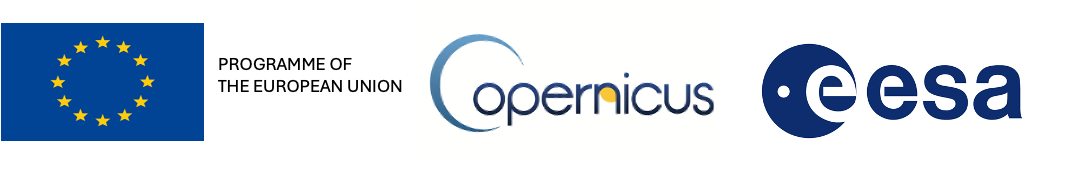

## Sentinel-3 Patchwork L1 OLCI EFR L2 SLSTR FPR SYN AOD product format prototype

## Table of Contents
1. [Introduction](#introduction)
2. [L1 OLCI_EFR](#l1-olci-efr)
   - [Open the product using EOPF API and visualize the tree structure](#open-the-product-using-eopf-api-and-visualize-the-tree-structure)
   - [Opening measurement data](#opening-measurement-data)
     - [Simple raster plot](#simple-raster-plot)
     - [Plot using the coordinates (lon,lat)](#plot-using-the-coordinates-lonlat)
     - [Open Meteorological conditions](#open-meteorological-conditions)
     - [Interpolate the atmo. temp. profile at p=832.2 hPa and plot](#interpolate-the-atmo-temp-profile-at-p8322-hpa-and-plot)
     - [Open sat/sun angles](#open-satsun-angles)
     - [Have a look at condition parameters for removed pixels](#have-a-look-at-condition-parameters-for-removed-pixels)
3. [SLSTR FRP](#slstr-frp)
   - [Opening measurement data (1D)](#opening-measurement-data-1d)
   - [Plot Active Fire pixels positions on a PlateCarree grid](#plot-active-fire-pixels-positions-on-a-platecarree-grid)
4. [SYN AOD](#syn-aod)
   - [Plot using the coordinates (lon,lat)](#plot-using-the-coordinates-lonlat)

## Introduction

In this notebook we will show an example of using Sentinel-3 L1 OLCI EFR, Sentinel-3 L2 SLSTR FPR, Sentinel-3 SYN AOD product

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import fsspec  # For remote access
import datatree

## L1 OLCI EFR

Product can only be accessed locally and also remotely, even if it is a zarr.zip



In [2]:
# Define the remote product path
remote_product_path = "https://eopf-public.s3.sbg.perf.cloud.ovh.net/eoproducts/S03OLCEFR_20230506T015316_0180_B117_T883.zarr.zip"

# Construct the fsspec mapper path
store = fsspec.get_mapper(f"zip::{remote_product_path}")

# Load it with datatree
dt = datatree.open_datatree(store, engine="zarr", consolidated=False, chunks={})

### Open the product using EOPF API and visualize the tree structure


In [3]:
print(dt)

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       other_metadata:  {'absolute_pass_number': 52368, 'cycle_number': 79, 'dat...
│       stac_discovery:  {'assets': [], 'bbox': [132.954, 29.0715, 115.986, 41.97...
├── DataTree('conditions')
│   ├── DataTree('geometry')
│   │       Dimensions:    (tp_rows: 4092, tp_columns: 77)
│   │       Coordinates:
│   │           latitude   (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>
│   │           longitude  (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>
│   │       Dimensions without coordinates: tp_rows, tp_columns
│   │       Data variables:
│   │           oaa        (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>
│   │           oza        (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>
│   │           saa        (tp_rows, tp_columns) flo

### Opening measurement data


In [4]:
rad = dt.measurements.oa01_radiance
rad.encoding

{'chunks': (1024, 1024),
 'preferred_chunks': {'rows': 1024, 'columns': 1024},
 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': 65535,
 'scale_factor': 0.013634907081723213,
 'add_offset': 0.0,
 'dtype': dtype('uint16'),
 'coordinates': 'time_stamp latitude longitude'}

Underlying data is dask.array



In [5]:
rad.data

dask.array<open_dataset-oa01_radiance, shape=(4092, 4865), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>

In [6]:
rad.attrs

{'long_name': 'TOA radiance for OLCI acquisition band oa01',
 'short_name': 'oa01_radiance',
 'standard_name': 'toa_upwelling_spectral_radiance',
 'units': 'mW.m-2.sr-1.nm-1',
 'valid_max': 65534,
 'valid_min': 0}

In [7]:
rad.units  ## Serving Ambiguity as a replacement for rad.is_scaled
rad.to_masked_array()
rad.sel()

<xarray.DataArray 'oa01_radiance' (rows: 4092, columns: 4865)> Size: 159MB
dask.array<open_dataset-oa01_radiance, shape=(4092, 4865), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    latitude    (rows, columns) float64 159MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    longitude   (rows, columns) float64 159MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    time_stamp  (rows) datetime64[ns] 33kB dask.array<chunksize=(1024,), meta=np.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      TOA radiance for OLCI acquisition band oa01
    short_name:     oa01_radiance
    standard_name:  toa_upwelling_spectral_radiance
    units:          mW.m-2.sr-1.nm-1
    valid_max:      65534
    valid_min:      0

#### Simple raster plot
Note that using xarray, data is correctly decoded and masked




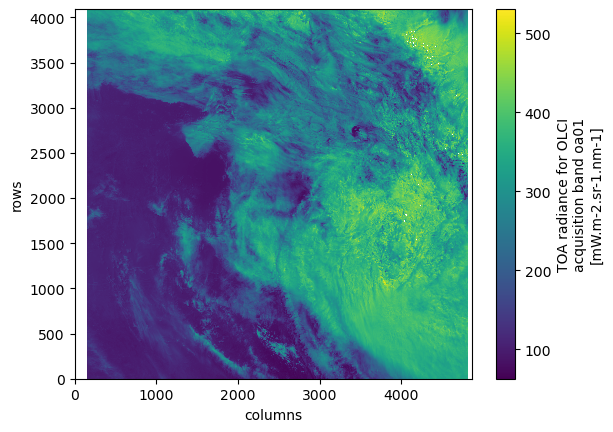

In [8]:
rad.plot()

#### Plot using the coordinates (lon,lat)


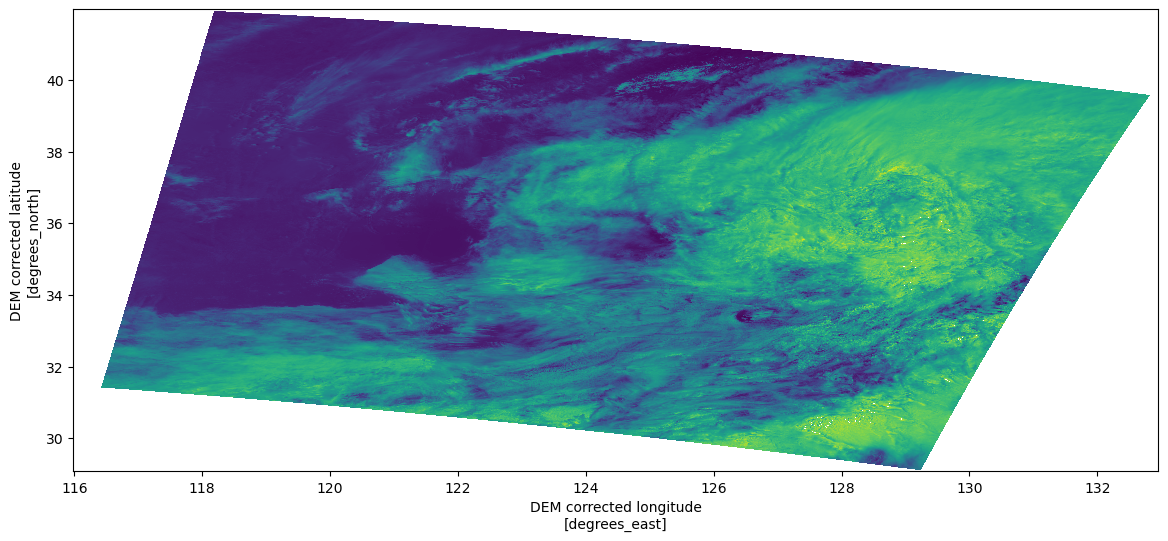

In [9]:
plt.figure(figsize=(14, 6))
ax = plt.axes()
rad.plot.pcolormesh(ax=ax, x="longitude", y="latitude", add_colorbar=False)

#### Open Meteorological conditions


In [10]:
meteo = dt.conditions.meteorology

#### Interpolate the atmo. temp. profile at p=832.2 hPa and plot


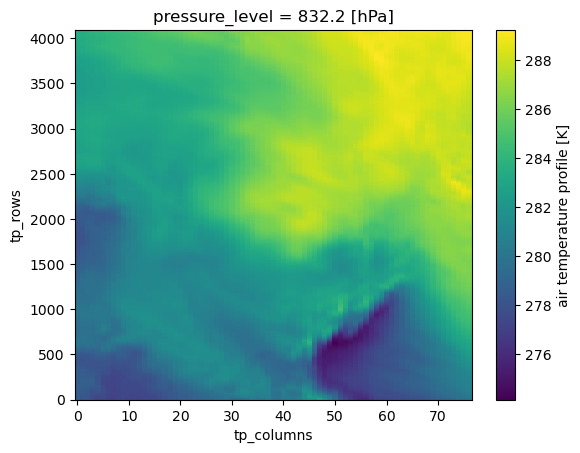

In [11]:
tp = meteo["atmospheric_temperature_profile"].interp(pressure_level=832.2)
tp.plot()

#### Open sat/sun angles
Angles are stored on a tiepoint subgrid





In [12]:
ds = dt.conditions.geometry
ds

DataTree('geometry', parent="conditions")
    Dimensions:    (tp_rows: 4092, tp_columns: 77)
    Coordinates:
        latitude   (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>
        longitude  (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>
    Dimensions without coordinates: tp_rows, tp_columns
    Data variables:
        oaa        (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>
        oza        (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>
        saa        (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>
        sza        (tp_rows, tp_columns) float64 3MB dask.array<chunksize=(4092, 77), meta=np.ndarray>

#### Have a look at condition parameters for removed pixels


In [13]:
ds = dt.conditions.orphans
ds

DataTree('orphans', parent="conditions")
    Dimensions:            (rows: 4092, removed_pixels: 150)
    Coordinates:
        altitude           (rows, removed_pixels) float32 2MB dask.array<chunksize=(1024, 150), meta=np.ndarray>
        latitude           (rows, removed_pixels) float64 5MB dask.array<chunksize=(1024, 150), meta=np.ndarray>
        longitude          (rows, removed_pixels) float64 5MB dask.array<chunksize=(1024, 150), meta=np.ndarray>
    Dimensions without coordinates: rows, removed_pixels
    Data variables:
        detector_index     (rows, removed_pixels) float32 2MB dask.array<chunksize=(1024, 150), meta=np.ndarray>
        frame_offset       (rows, removed_pixels) float32 2MB dask.array<chunksize=(1024, 150), meta=np.ndarray>
        nb_removed_pixels  (rows) uint16 8kB dask.array<chunksize=(1024,), meta=np.ndarray>
        sza                (rows, removed_pixels) float64 5MB dask.array<chunksize=(1024, 150), meta=np.ndarray>

## SLSTR FRP


In [14]:
# Define the remote product path
remote_product_path = "https://eopf-public.s3.sbg.perf.cloud.ovh.net/eoproducts/S03SLSFRP_20200908T182648_0179_A298_S883.zarr.zip"

# Construct the fsspec mapper path
store = fsspec.get_mapper(f"zip::{remote_product_path}")

# Load it with datatree
dt = datatree.open_datatree(store, engine="zarr", consolidated=False, chunks={})

### Opening measurement data (1D)
Cannot find the lat/lon in this product ....




In [15]:
meas_in = dt.measurements.inadir
meas_in

DataTree('inadir', parent="measurements")
│   Dimensions:                 (fires: 1486, rows: 1200, columns: 1500)
│   Coordinates:
│       latitude                (fires) float64 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       longitude               (fires) float64 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       x                       (rows, columns) float64 14MB dask.array<chunksize=(600, 750), meta=np.ndarray>
│       y                       (rows, columns) float64 14MB dask.array<chunksize=(600, 750), meta=np.ndarray>
│   Dimensions without coordinates: fires, rows, columns
│   Data variables: (12/23)
│       bt_mir                  (fires) float64 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       bt_window               (fires) float64 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       classification          (fires) uint8 1kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       day_night               (fires) int8 1kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       f1_fire_pixel_radiance  (fires) float64 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       flags                   (rows, columns) uint32 7MB dask.array<chunksize=(1200, 1500), meta=np.ndarray>
│       ...                      ...
│       satellite_zenith_angle  (fires) float64 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       sun_zenith_angle        (fires) float64 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       tcwv                    (fires) float64 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       time                    (fires) datetime64[ns] 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       transmittance_mwir      (fires) float64 12kB dask.array<chunksize=(1000,), meta=np.ndarray>
│       used_channel            (fires) uint8 1kB dask.array<chunksize=(1000,), meta=np.ndarray>
└── DataTree('orphan')
        Dimensions:    (rows: 1200, orphan_pixels: 187)
        Coordinates:
            latitude   (rows, orphan_pixels) float64 2MB dask.array<chunksize=(1200, 187), meta=np.ndarray>
            longitude  (rows, orphan_pixels) float64 2MB dask.array<chunksize=(1200, 187), meta=np.ndarray>
            x          (rows, orphan_pixels) float64 2MB dask.array<chunksize=(1200, 187), meta=np.ndarray>
            y          (rows, orphan_pixels) float64 2MB dask.array<chunksize=(1200, 187), meta=np.ndarray>
        Dimensions without coordinates: rows, orphan_pixels
        Data variables:
            *empty*

### Plot Active Fire pixels positions on a PlateCarree grid


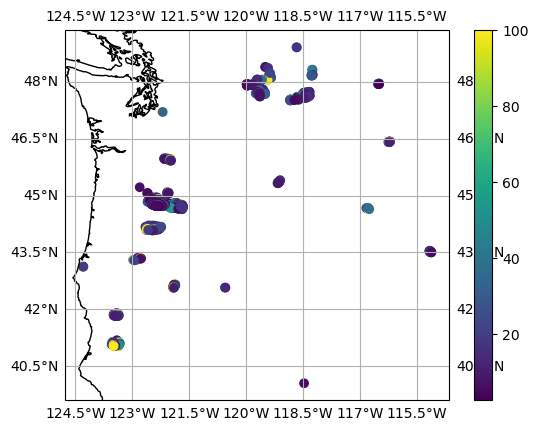

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.scatter(meas_in.longitude, meas_in.latitude, c=meas_in.frp_mwir, vmax=100)
plt.colorbar()

## SYN AOD


In [17]:
# Define the remote product path
remote_product_path = "https://eopf-public.s3.sbg.perf.cloud.ovh.net/eoproducts/S03SYNAOD_20191227T124211_0060_A109_T883.zarr.zip"

# Construct the fsspec mapper path
store = fsspec.get_mapper(f"zip::{remote_product_path}")

# Load it with datatree
dt = datatree.open_datatree(store, engine="zarr", consolidated=False, chunks={})

In [18]:
aod550 = dt.measurements.aod_550
aod550

<xarray.DataArray 'aod_550' (rows: 90, columns: 324)> Size: 233kB
dask.array<open_dataset-aod_550, shape=(90, 324), dtype=float64, chunksize=(90, 324), chunktype=numpy.ndarray>
Coordinates:
    latitude   (rows, columns) float32 117kB dask.array<chunksize=(90, 324), meta=np.ndarray>
    longitude  (rows, columns) float32 117kB dask.array<chunksize=(90, 324), meta=np.ndarray>
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      aerosol optical thickness at 550 nm
    short_name:     aod_550
    standard_name:  atmosphere_optical_thickness_due_to_ambient_aerosol
    valid_max:      4.000999927520752
    valid_min:      0.0

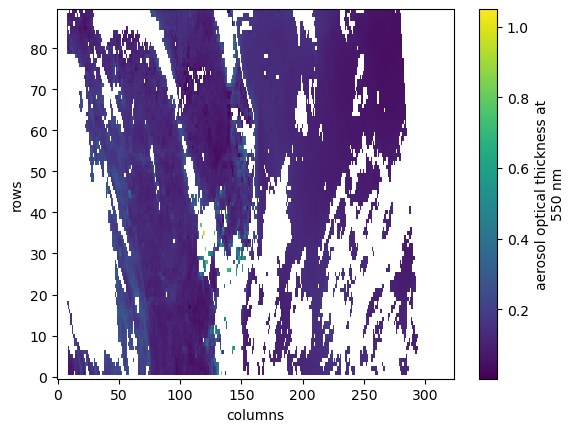

In [19]:
aod550.plot()

### Plot using the coordinates (lon,lat)
Note that in SYN AOD product, lat/lon are undefined when the data is missing, which is not correctly handled by matplotlib pcolormesh




In [20]:
# Remove margins
aod550_dropna = aod550.dropna("columns", how="all")
aod550_dropna = aod550_dropna.dropna("rows", how="all")

# Fill remaining missing values
aod550_dropna["latitude"] = (
    ["rows", "columns"],
    aod550_dropna.latitude.bfill("columns").data,
)
aod550_dropna["longitude"] = (
    ["rows", "columns"],
    aod550_dropna.longitude.bfill("columns").data,
)

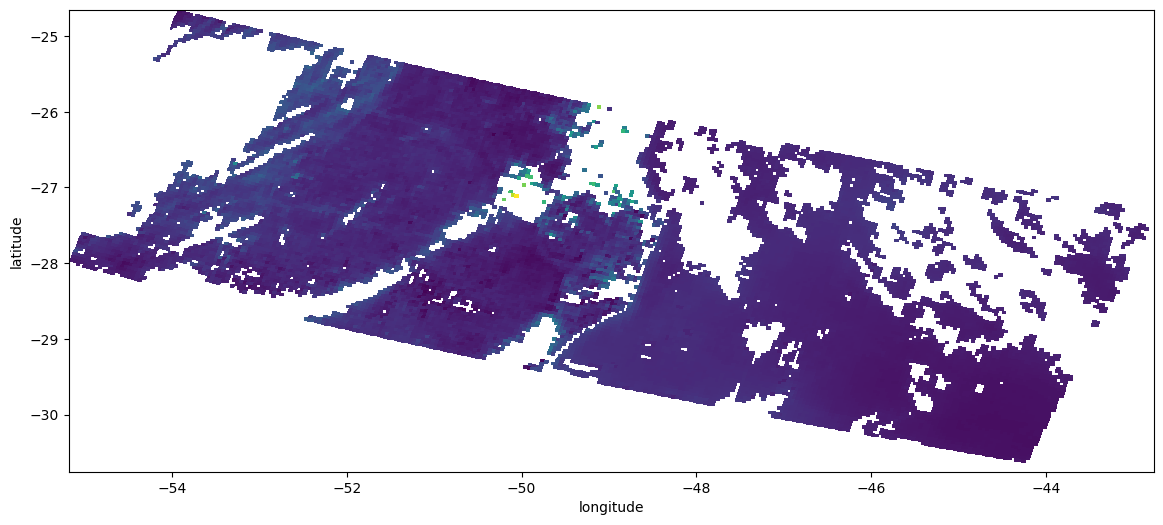

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
ax = plt.axes()
aod550_dropna.plot.pcolormesh(ax=ax, x="longitude", y="latitude", add_colorbar=False)